In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Heston model parameter

T_days = 182 #nb de jours
h= 1/365 #pas de temps journalier
dim = T_days+1 #points temporels
Tbar = 50 #limite d'excurssion
Nsim = 1000 #nb de simulations

S0 = 100 # Prix du titre sous-jacent
K = S0 # at the money option
T = 1 # time to maturity
r = 0.1  #risk rate
sigma = 0.25 # volatilité de la variance
v0 = sigma**2 #starting volatility
Sbar = 130.0

theta = 0.1 # Long term mean of the volatility
kappa = 2 # Retour à la moyenne
eta = 0.40
rho = -0.5 # Corrélation entre le prix du sous-jacent et la volatilité

In [3]:
rng = np.random.default_rng(42)

In [4]:
X = np.full((Nsim,), np.log(S0))
v = np.full((Nsim,), v0)

# Compteur d'excursions consécutives au-dessus de la barrière
excursion = np.zeros(Nsim, dtype=np.int32)
knocked = np.zeros(Nsim, dtype=bool)

disc = np.exp(-r * T_days * h)

In [5]:
for j in range(1, dim):
    Zs = rng.standard_normal(Nsim)
    Zv_perp = rng.standard_normal(Nsim)
    Zv = rho * Zs + np.sqrt(1.0 - rho**2) * Zv_perp

    # Mise à jour log-prix et variance
    v_clipped = np.maximum(v, 0.0)

    X = X + (r - 0.5 * v_clipped) * h + np.sqrt(v_clipped * h) * Zs
    v = v + kappa * (theta - v) * h + eta * np.sqrt(v_clipped * h) * Zv
    v = np.maximum(v, 0.0)  # re-clipping

    # Mise à jour barrière parisienne (comptage de jours consécutifs >= Sbar)
    S = np.exp(X)
    above = S >= Sbar
    excursion = np.where(above, excursion + 1, 0)
    knocked |= (excursion > Tbar)  # KO dès que l'on dépasse la limite

In [6]:
# Payoffs
ST = np.exp(X)
euroCall = disc * np.mean(np.maximum(ST - K, 0.0))
# Parisian Up-and-Out: payoff uniquement si jamais KO
payoff_parisian = np.where(knocked, 0.0, np.maximum(ST - K, 0.0))
prixUaO = disc * payoff_parisian.mean()

euroCall, prixUaO

(np.float64(10.495711658940419), np.float64(8.873594297426752))

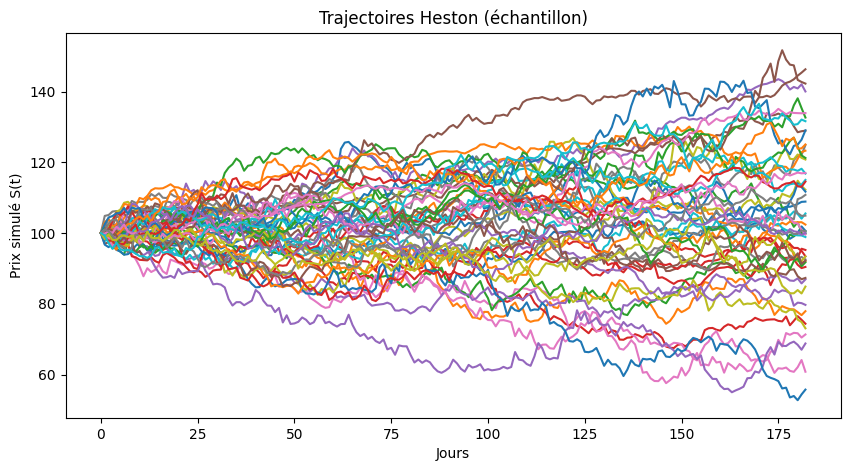

In [7]:
# Visualisation de la simulation

# Échantillonner quelques trajectoires pour garder le graphe lisible
m_show = 50  # nombre de courbes à afficher
idx = rng.choice(Nsim, size=m_show, replace=False)

# Pour tracer, on refait une simulation compacte (ou on stocke à la volée dans un grand tableau si RAM ok)
X_paths = np.full((m_show,), np.log(S0))
v_paths = np.full((m_show,), v0)
paths = np.empty((m_show, dim))
paths[:, 0] = np.exp(X_paths)

for j in range(1, dim):
    Zs = rng.standard_normal(m_show)
    Zv_perp = rng.standard_normal(m_show)
    Zv = rho * Zs + np.sqrt(1.0 - rho**2) * Zv_perp

    v_clip = np.maximum(v_paths, 0.0)
    X_paths = X_paths + (r - 0.5 * v_clip) * h + np.sqrt(v_clip * h) * Zs
    v_paths = v_paths + kappa * (theta - v_paths) * h + eta * np.sqrt(v_clip * h) * Zv
    v_paths = np.maximum(v_paths, 0.0)
    paths[:, j] = np.exp(X_paths)

plt.figure(figsize=(10, 5))
plt.plot(paths.T)
plt.xlabel("Jours")
plt.ylabel("Prix simulé S(t)")
plt.title("Trajectoires Heston (échantillon)")
plt.show()

In [8]:
# Compter les chemins knockés (True)
nb_knocked = int(np.count_nonzero(knocked))   # équiv. à int(knocked.sum())
ratio_knocked = nb_knocked / len(knocked)

# Payoff actualisé par chemin pour la Parisian Up-and-Out
# (en supposant que tu as déjà ST, K, disc, knocked définis)
discounted_payoff_parisian = disc * np.where(knocked, 0.0, np.maximum(ST - K, 0.0))

# Prix (déjà calculé ailleurs peut-être : prixUaO = discounted_payoff_parisian.mean())
prixUaO = discounted_payoff_parisian.mean()

# Erreur-type de l’estimateur MC (unbiased std avec ddof=1)
n_sims = discounted_payoff_parisian.shape[0]
std_error = discounted_payoff_parisian.std(ddof=1) / np.sqrt(n_sims)

print("Qté knocked: ", nb_knocked, f"({ratio_knocked:.2%})")
print("Prix Parisian : ", prixUaO)
print("Standard Error: ", std_error)

Qté knocked:  37 (3.70%)
Prix Parisian :  8.873594297426752
Standard Error:  0.36526618277889616
